# PlotBot
UCB Extension HW7 written by A. Lam

# Setup

In [1]:
# Dependencies
!pip install vaderSentiment==2.5
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time, strftime, localtime, sleep
import math
import sys
sys.path.append('/Users/alam/homework/Quarantine/Keys')
import Twit
import re
from datetime import datetime, timedelta

In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
consumer_key = Twit.CKey
consumer_secret = Twit.CSecret
access_token = Twit.AToken
access_token_secret = Twit.ASecret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
def scan_tweets(target = '@yo__xan', check_count = 100, debug = False):
    MAX_STATUS_PER_QUERY = 100
    oldest_tweet = ''
    iterations = math.ceil(check_count/MAX_STATUS_PER_QUERY)
    if debug:
        print('iterations needed for %s tweets: %s' % (check_count,iterations))
    result_template = pd.DataFrame({
        'tweet': [],
        'username': [],
        'id':[],
        'created_at': []
        })
    
#     initialize result output
    result = result_template
    count_tweets = 0
    for iteration in range(iterations):
        public_tweets = api.search(target, count = check_count, result_type='recent',
                              max_id = oldest_tweet)
        if debug:
            print('iteration #%d' % (iteration+1))
        for tweet in public_tweets['statuses']:
            this_result = pd.DataFrame({
                'username' : tweet['user']['screen_name'],
                'tweet': tweet['text'].encode('UTF-8'),
                'id' : tweet['id_str'],
                'created_at': tweet['created_at']
                },index=[0])
            oldest_tweet = tweet['id_str']
            count_tweets += 1
            result = pd.concat([result,this_result],axis = 0, ignore_index = True)
            if count_tweets == check_count:
                break
            
    if debug:
        print('%s tweets returned out of %s requested.' % (len(result),check_count))
    return result     

In [4]:
def vader_tweets(target_user,n_tweets = 100):
# Pulls most recent tweets of target_user and performs VADER analysis.
# Output resulting analysis in pandas dataframe.
    n_pages = math.ceil(n_tweets/20) + 1 #accomodate for pagination starting at 1
    output = pd.DataFrame({'User' : [],
                'Tweet': [],
                'TweetsAgo': [],           
                'Compound Score' : [],
                'Positive Score' : [],
                'Neutral Score' : [],
                'Negative Score' : []})

    # script execution
    counter = 0
    for i in range(1,n_pages):
        public_tweets = api.user_timeline(target_user, page = i)
        for tweet in public_tweets:
            counter += 1
            target_string = tweet['text']
            compound = analyzer.polarity_scores(target_string)["compound"]
            pos = analyzer.polarity_scores(target_string)["pos"]
            neu = analyzer.polarity_scores(target_string)["neu"]
            neg = analyzer.polarity_scores(target_string)["neg"]
            this_output = pd.DataFrame({
                'User': target_user,
                'Tweet': target_string,
                'TweetsAgo': counter, 
                'Compound Score' : compound,
                'Positive Score' : pos,
                'Neutral Score' : neu,
                'Negative Score' : neg
            },index=[counter])
            output = output.append(this_output)
            if counter == n_tweets:
                break
    return output

In [5]:
def plot_sentiment(tweet_df,save = True):
#Given a dataframe of analyzed tweets, generate a titled plot of Tweet Polarity
    if len(tweet_df['User'].unique()) == 1:
        this_user = tweet_df['User'].unique()[0][1:]
        plt.plot(tweet_df['TweetsAgo'],tweet_df['Compound Score'],'o:')
        plt.xlabel('Tweets Ago')
        plt.ylabel('Tweet Polarity')
        plt.title("Sentiment Analysis of %s's tweets on %s" % (this_user,strftime('%d%b%Y', localtime())))
        plt.grid(True)
        if save:
            file_name = '%s_SentimentAnalysis%s.png' % (this_user,strftime('%d%b%Y', localtime()))
            plt.savefig(file_name)
        else:
            print('figure not saved')
            file_name = ''
        plt.show()
        return file_name
    else:
        print('More than one user in input dataframe')

In [6]:
def create_tweet_datetime_obj(dirty_string):
    # Note: method used strips timezone off. ONLY USE UTC
    clean_string = dirty_string[4:20]+dirty_string[-4:]
    datetime_obj = datetime.strptime(clean_string, '%b %d %I:%M:%S %Y')
    return datetime_obj

In [ ]:
def reply_to_tweets(repeat = 10, only_after_announcement = True):
    SECONDS_IN_MINUTE = 60
    key_string = 'please analyze @'
    key_string_instr = key_string[:-1] + '[at]twitter handle'
    response = api.update_status('Who wants a sentiment analysis of their tweets? ' \
                      'tweet at me: "%s". ' \
                      "It doesn't even need to be you! " \
                      'replying from %s PST for the next %s minutes' % 
                      (key_string_instr,strftime('%H:%M', localtime()),repeat)
                     )
    # track when announcing tweet was made, and only reply to tweets made after announcement
    if only_after_announcement:
        reply_after = create_tweet_datetime_obj(response['created_at'])
    else:
        reply_after = datetime.utcnow() - timedelta(1) #assume backlog only spans to yesterday
    
    while repeat > 0:
        results = scan_tweets()
        for index in results.index:
            tweet = str(results.loc[index,'tweet'])
            author = str(results.loc[index,'username'])
            tweet_id = str(results.loc[index,'id'])
            time_tweeted_obj = create_tweet_datetime_obj(str(results.loc[index,'created_at']))
#             Determine if tweet meets key string criteria
            reply = re.search(key_string,tweet)
            
            if reply and time_tweeted_obj > reply_after:
                analysis_target = '@' + re.match('[a-zA-Z0-9_]+',tweet[reply.end():]).group()
                analysis_results = vader_tweets(analysis_target)
                filename = plot_sentiment(analysis_results)
                try:
                    upload = api.media_upload(filename=filename)
                    media_ids = [upload['media_id_string']]
                    api.update_status(status = '@%s Here you go! ' \
                                      'A VADER sentiment analysis of %s' % (author, analysis_target), 
                                  in_reply_to_status = tweet_id, media_ids=media_ids)
                except:
                    print('failed to tweet. Possibly duplicate.')
        # Update reply after to prevent repeats
        reply_after = datetime.utcnow()
        repeat -= 1
        sleep(SECONDS_IN_MINUTE)

# Test Code

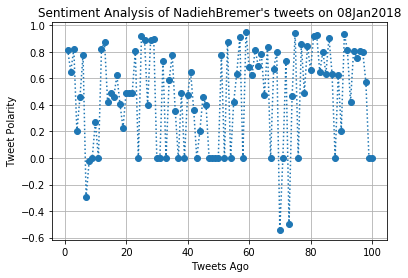

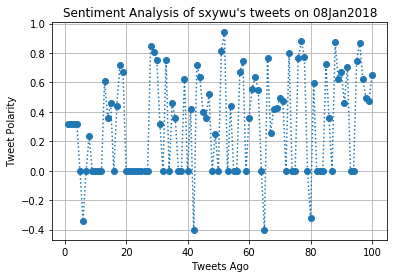

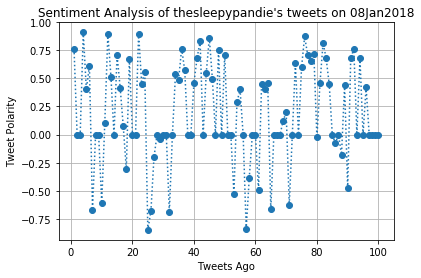

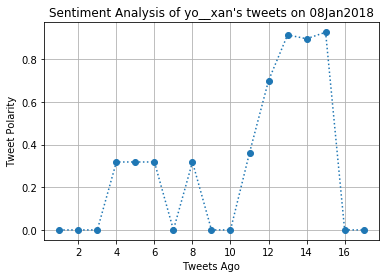

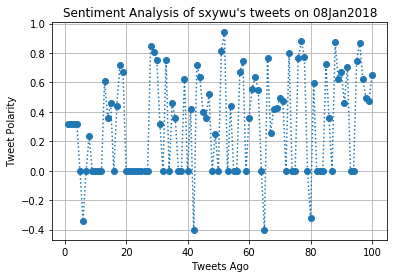

In [ ]:
reply_to_tweets(repeat = 15, only_after_announcement=False)

In [ ]:
# output = vader_tweets('@sxywu')
# filename = plot_sentiment(output,save=False)
# print(filename)